In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Binarizer, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
covid = pd.read_excel('dataset.xlsx')
pd.set_option('display.max_row',111)
pd.set_option('display.max_column',111)
covid.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [3]:
df = covid.copy()
n, m = df.shape
target = 'SARS-Cov-2 exam result'

rate = df.isna().sum()/n
blood_var = list(df.columns[(rate > 0.88) & (rate < 0.9)])
viral_var = list(df.columns[(rate > 0.75) & (rate < 0.80)])
key_var = [target, 'Patient age quantile']

df = df[key_var + blood_var + viral_var]
df.head()

,SARS-Cov-2 exam result,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,negative,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,negative,17,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,negative,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,negative,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,negative,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

In [5]:
def encodage(tab):
    
    dict = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    
    for var in tab.select_dtypes('object').columns:
        tab.loc[:, var] = tab[var].map(dict)
    
    return tab

def features_engineering(tab):
    tab['Is sick'] = (tab[viral_var].sum(axis=1) >= 1)
    tab = tab.drop(viral_var, axis=1)
    return tab

def imputation(tab):
    return tab.dropna()

def preprocessing(tab):
    
    tab = encodage(tab)
    tab = features_engineering(tab)
    tab = imputation(tab)
    
    X = tab.drop(target, axis=1)
    y = tab[target]
    
    print(y.value_counts())
    return X, y

def evaluation(mod):
    
    mod.fit(X_train, y_train)
    y = mod.predict(X_test)
    
    print(confusion_matrix(y_test,y))
    print(classification_report(y_test,y))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1', train_sizes=np.linspace(0.1,1,10))
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='val score')
    plt.legend()
    plt.show()

In [7]:
X_train, y_train = preprocessing(df_train)
X_test, y_test = preprocessing(df_test)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


/Users/guillaumesaes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
preprocess = make_pipeline(PolynomialFeatures(2, include_bias=False),
                      SelectKBest(f_classif, k=10))
RandomForest = make_pipeline(preprocess, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocess, AdaBoostClassifier(random_state=0))
KNeighbors = make_pipeline(preprocess, StandardScaler(), KNeighborsClassifier())
SVM = make_pipeline(preprocess, StandardScaler(), SVC(random_state=0))

list_models = {'RandomForest' : RandomForest, 'AdaBoost' : AdaBoost, 'KNeighbors' : KNeighbors, 'SVM' : SVM}

RandomForest
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111



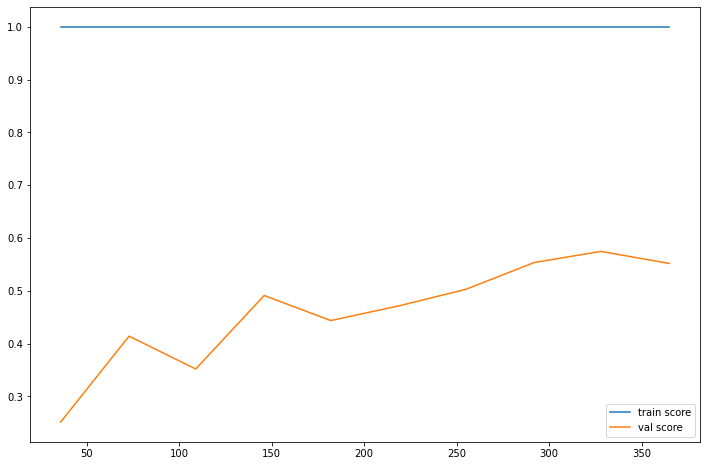

AdaBoost
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



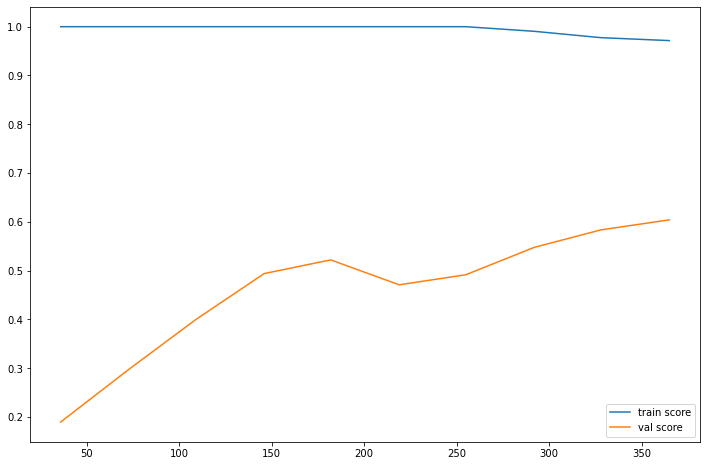

KNeighbors
[[88  7]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        95
           1       0.53      0.50      0.52        16

    accuracy                           0.86       111
   macro avg       0.72      0.71      0.72       111
weighted avg       0.86      0.86      0.86       111



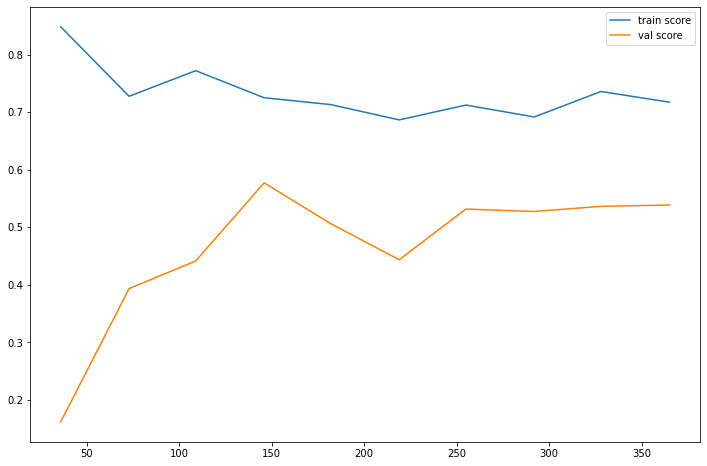

SVM
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71       111
weighted avg       0.87      0.88      0.87       111



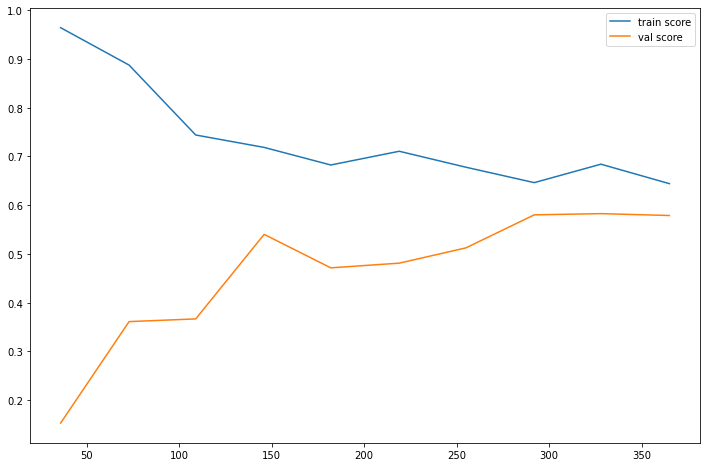

In [9]:
for name, model in list_models.items():
    print(name)
    evaluation(model)

In [10]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [11]:
params = {'svc__gamma' : [1e-4, 1e-3, 1e-2, 1e-1],
          'svc__C' : [1, 10, 100, 1000]}
grid = GridSearchCV(SVM, params, scoring='recall', cv=4)
grid.fit(X_train, y_train)

print('Les meilleurs paramètres du modèle sont : ', grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

Les meilleurs paramètres du modèle sont :  {'svc__C': 10, 'svc__gamma': 0.1}
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



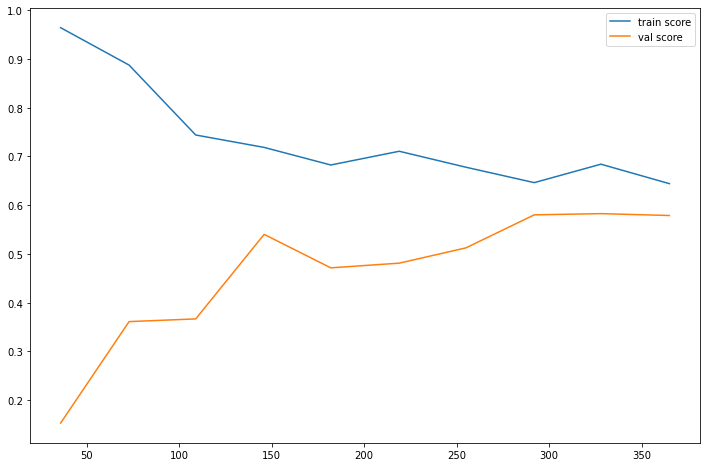

In [12]:
evaluation(grid.best_estimator_)

In [13]:
params = {'svc__gamma' : [1e-3],
          'svc__C' : [1000], 
          'pipeline__polynomialfeatures__degree' : [3], 
          'pipeline__selectkbest__k' : range(54,60)}
grid = GridSearchCV(SVM, params, scoring='recall', cv=4)
grid.fit(X_train, y_train)

print('Les meilleurs paramètres du modèle sont : ', grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

Les meilleurs paramètres du modèle sont :  {'pipeline__polynomialfeatures__degree': 3, 'pipeline__selectkbest__k': 54, 'svc__C': 1000, 'svc__gamma': 0.001}
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        95
           1       0.56      0.56      0.56        16

    accuracy                           0.87       111
   macro avg       0.74      0.74      0.74       111
weighted avg       0.87      0.87      0.87       111



In [14]:
preprocess = make_pipeline(PolynomialFeatures(3, include_bias=False),
                      SelectKBest(f_classif, k=54))
SVM = make_pipeline(preprocess, StandardScaler(), SVC(gamma=0.001, C=1000, random_state=0))

SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        95
           1       0.56      0.56      0.56        16

    accuracy                           0.87       111
   macro avg       0.74      0.74      0.74       111
weighted avg       0.87      0.87      0.87       111



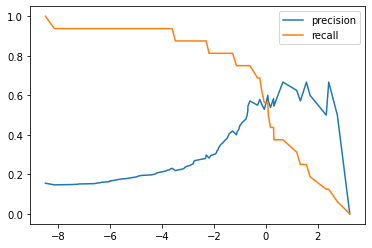

In [15]:
prec, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))
plt.figure()
plt.plot(threshold, prec[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()
plt.show()

In [16]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

In [17]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-0.7)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92        95
           1       0.52      0.75      0.62        16

    accuracy                           0.86       111
   macro avg       0.74      0.82      0.77       111
weighted avg       0.89      0.86      0.87       111



In [18]:
AdaBoost

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('adaboostclassifier', AdaBoostClassifier(random_state=0))])

In [19]:
params = {'adaboostclassifier__n_estimators' : range(60,100),
          'adaboostclassifier__learning_rate' : [0.9, 0.95, 1]}
grid = RandomizedSearchCV(AdaBoost, params, scoring='recall', cv=4, n_iter=50)
grid.fit(X_train, y_train)

print('Les meilleurs paramètres du modèle sont : ', grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

Les meilleurs paramètres du modèle sont :  {'adaboostclassifier__n_estimators': 98, 'adaboostclassifier__learning_rate': 0.9}
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



In [20]:
params = {'adaboostclassifier__n_estimators' : range(85,100),
          'adaboostclassifier__learning_rate' : [0.9, 0.91, 0.92, 0.93, 0.94],
          'adaboostclassifier__algorithm' : ['SAMME', 'SAMME.R']}
grid = GridSearchCV(AdaBoost, params, scoring='recall', cv=4)
grid.fit(X_train, y_train)

print('Les meilleurs paramètres du modèle sont : ', grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

Les meilleurs paramètres du modèle sont :  {'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 0.9, 'adaboostclassifier__n_estimators': 96}
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



In [21]:
prec, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

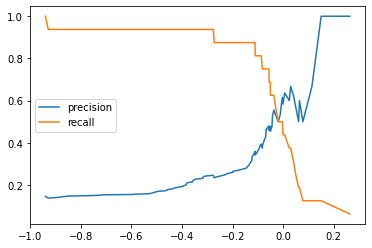

In [22]:
prec, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))
plt.figure()
plt.plot(threshold, prec[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()
plt.show()

In [152]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-0.04)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        95
           1       0.56      0.62      0.59        16

    accuracy                           0.87       111
   macro avg       0.75      0.77      0.76       111
weighted avg       0.88      0.87      0.88       111

